https://app.jedha.co/course/linear-regression-exercises-pt/californian-housing-market-pt
# Californian Housing Market

## Imports & loading

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE


In [63]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)    
data = np.c_[california_housing.data, california_housing.target]
columns = np.append(california_housing.feature_names, ["target"])
dataset = pd.DataFrame(data, columns=columns)

## EDA & cleaning

In [32]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 20640

Display of dataset: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basics statistics: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



Percentage of missing values: 


MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
target        0.0
dtype: float64

<AxesSubplot:>

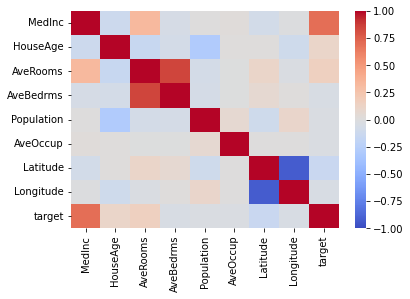

In [4]:
# Plot the heatmap and annotation on it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
dataset_correlation = dataset.corr()
sns.heatmap(dataset_correlation, xticklabels=dataset_correlation.columns, yticklabels=dataset_correlation.columns, cmap='coolwarm', vmin=-1, vmax = 1)

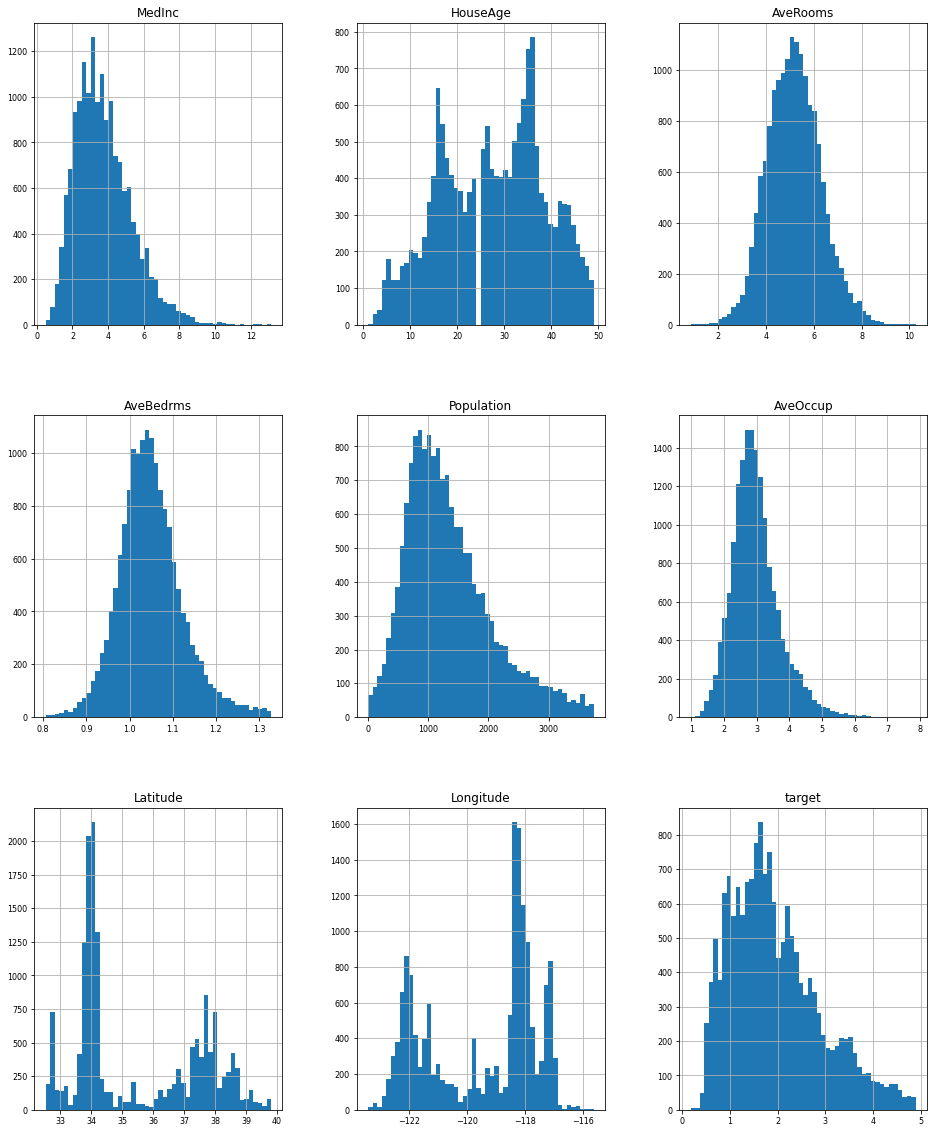

In [14]:
# listing dataframes types
list(set(dataset.dtypes.tolist()))
# include only float and integer
df_num = dataset.select_dtypes(include = ['float64', 'int64', 'UInt32'])
# display what                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              has been selected
df_num.head()
# plot
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [64]:
# Drop lines containing invalid values or outliers
print("Number of rows before removing NAs : {}".format(dataset.shape[0]))
print()
dataset.dropna(inplace=True)
print("Number of rows after removing NAs : {}".format(dataset.shape[0]))
print()

print("Number of rows before removing outliers : {}".format(dataset.shape[0]))
print()

columns_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'Population']
for column_to_clean in columns_to_clean:
    upper_limit = dataset[column_to_clean].mean() + 2 * dataset[column_to_clean].std()
    lower_limit = dataset[column_to_clean].mean() - 2 * dataset[column_to_clean].std()
    dataset = dataset[(dataset[column_to_clean] > lower_limit) & (dataset[column_to_clean] < upper_limit)]
    
print("Number of rows AFTER removing outliers : {}".format(dataset.shape[0]))
print()

Number of rows before removing NAs : 20640

Number of rows after removing NAs : 20640

Number of rows before removing outliers : 20640

Number of rows AFTER removing outliers : 18526



In [65]:
print("Number of rows before removing grouped values : {}".format(dataset.shape[0]))
print()
#Drop lines with HouseAge = 50 (group)
dataset = dataset[dataset['HouseAge'] <= 49]
# Drop lines with Price = 5 (group)
dataset = dataset[dataset['target'] < 4.9]
# Drop lines with AveOccup > 7 (group)
dataset = dataset[dataset['AveOccup'] < 8]
print("Number of rows AFTER removing grouped values : {}".format(dataset.shape[0]))
print()

Number of rows before removing grouped values : 18526

Number of rows AFTER removing grouped values : 16357



In [ ]:
sns.pairplot(dataset)

In [14]:
fig = go.Figure()
fig.add_scatter(y=dataset['target'], x=dataset['MedInc'], mode = 'markers')
fig.upda                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            te_layout(width=1200,height=600) 

## Preprocessing

In [17]:
print(dataset.dtypes)

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
target        float64
dtype: object


**Analysis :**

* MedInc        median income in block
* HouseAge      median house age in block
* AveRooms      average number of rooms
* AveBedrms     average number of bedrooms
* Population    block population
* AveOccup      average house occupancy
* Latitude      house block latitude / TO DROP
* Longitude     house block longitude / TO DROP



In [66]:
# Drop some columns
useless_cols = ['Latitude', 'Longitude']
# Date : is a timestamp, useless as is and correlated
# Day : could be related to sales if people spend more

print("Dropping useless columns...")
dataset = dataset.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis

print("...Done.")
print(dataset.head())

Dropping useless columns...
...Done.
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  target
0   8.3252      41.0  6.984127   1.023810       322.0  2.555556   4.526
1   8.3014      21.0  6.238137   0.971880      2401.0  2.109842   3.585
8   2.0804      42.0  4.294118   1.117647      1206.0  2.026891   2.267
20  1.3578      40.0  4.524096   1.108434       409.0  2.463855   1.475
21  1.7135      42.0  4.478142   1.002732       929.0  2.538251   1.598


In [67]:
# Separate target variable Y from features X
target_name = 'target'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0     4.526
1     3.585
8     2.267
20    1.475
21    1.598
Name: target, dtype: float64

    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
0   8.3252      41.0  6.984127   1.023810       322.0  2.555556
1   8.3014      21.0  6.238137   0.971880      2401.0  2.109842
8   2.0804      42.0  4.294118   1.117647      1206.0  2.026891
20  1.3578      40.0  4.524096   1.108434       409.0  2.463855
21  1.7135      42.0  4.478142   1.002732       929.0  2.538251



In [68]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
Xvalues = X.values
Ylist = Y.tolist()
print("...Done")
print(Xvalues[0:5,:])
print()
print(Ylist[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[8.32520000e+00 4.10000000e+01 6.98412698e+00 1.02380952e+00
  3.22000000e+02 2.55555556e+00]
 [8.30140000e+00 2.10000000e+01 6.23813708e+00 9.71880492e-01
  2.40100000e+03 2.10984183e+00]
 [2.08040000e+00 4.20000000e+01 4.29411765e+00 1.11764706e+00
  1.20600000e+03 2.02689076e+00]
 [1.35780000e+00 4.00000000e+01 4.52409639e+00 1.10843373e+00
  4.09000000e+02 2.46385542e+00]
 [1.71350000e+00 4.20000000e+01 4.47814208e+00 1.00273224e+00
  9.29000000e+02 2.53825137e+00]]

[4.526, 3.585, 2.267, 1.475, 1.598]


In [69]:
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(Xvalues, Ylist, test_size=0.1, random_state=0)
# test_size indicates the proportion of rows from X and Y that will go into the test dataset while 
# maintaining the correspondance between the rows from X and Y 

# random_state is an argument that can be found in all functions that have a pseudo-random behaviour
# if random_state is not stated the function will derive a different random result everytime the cell 
# runs, if random_state is given a value the results will be the same everytime the cell runs while
# each different value of radom_state will derive a specific result
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [22]:
print(dataset.dtypes)

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
target        float64
dtype: object


In [61]:
# Create pipeline for numeric features
numeric_features = [0,1,2,3,4,5] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
])

In [70]:
# Create pipeline for categorical features
categorical_features = [] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[                                 
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


In [71]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [39]:
# If using A Box Cox transformation
# preprocessor = PowerTransformer(method='box-cox', standardize=True)

In [72]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

Performing preprocessings on train set...
[[3.38920000e+00 2.00000000e+01 4.19549370e+00 1.01855533e+00
  2.95700000e+03 1.95957588e+00]
 [4.23080000e+00 4.90000000e+01 6.32867133e+00 1.01398601e+00
  1.00600000e+03 2.34498834e+00]
 [4.54860000e+00 3.20000000e+01 5.52552553e+00 9.27927928e-01
  8.28000000e+02 2.48648649e+00]
 [3.72370000e+00 4.20000000e+01 3.73244147e+00 1.01337793e+00
  1.08200000e+03 3.61872910e+00]
 [1.92860000e+00 3.80000000e+01 2.71428571e+00 9.28571429e-01
  4.45000000e+02 3.17857143e+00]]
...Done.
[[-0.22741271 -0.68878956 -0.88068079 -0.4143117   2.23839504 -1.3639213 ]
 [ 0.31307962  1.92589874  1.03115862 -0.47541099 -0.48270264 -0.84238469]
 [ 0.51717713  0.39315043  0.31134711 -1.62614834 -0.73096271 -0.65091071]
 [-0.01259012  1.29476709 -1.29568679 -0.48354211 -0.37670396  0.88122957]
 [-1.1654392   0.93412042 -2.20819884 -1.61754368 -1.26514026  0.28561226]]



## Training

In [73]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")


Train model...
...Done.


In [74]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


Predictions on training set...
...Done.
[2.24678778 2.30965488 2.24385841 ... 2.03282548 1.67718831 1.68753638]



## Model evaluation

In [43]:
X_train.shape

(14721, 6)

In [75]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on test set...
[[3.17420000e+00 2.00000000e+01 4.22871046e+00 1.23844282e+00
  1.40300000e+03 3.41362530e+00]
 [2.79400000e+00 1.50000000e+01 4.85582468e+00 1.03690888e+00
  1.93300000e+03 2.22952710e+00]
 [1.97980000e+00 4.90000000e+01 4.82236842e+00 1.09868421e+00
  1.36100000e+03 2.23848684e+00]
 [5.75600000e+00 1.60000000e+01 6.11749347e+00 1.02610966e+00
  2.00700000e+03 5.24020888e+00]
 [4.40870000e+00 3.00000000e+00 5.38596491e+00 1.27631579e+00
  7.93000000e+02 1.73903509e+00]]
...Done.
[[-0.36549    -0.68878956 -0.8509106   2.52594362  0.07100099  0.603685  ]
 [-0.60966204 -1.13959788 -0.28886566 -0.16889476  0.81020231 -0.99862578]
 [-1.13255754  1.92589874 -0.31885051  0.65714242  0.01242277 -0.98650155]
 [ 1.29259353 -1.04943622  0.84189255 -0.31329801  0.91341155  3.07540108]
 [ 0.42733056 -2.22153787  0.18626729  3.03236713 -0.77977789 -1.66235506]]



In [76]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


Predictions on test set...
...Done.
[1.97598704 1.51903142 1.64298812 ... 1.4309405  2.76715316 1.69529996]



In [77]:
# Print Adjusted R^2 scores
# n = number of observation, p = number of features

ntrain = len(Y_train)
ntest = len(Y_test)
p = X_test.shape[1]

r2train = r2_score(Y_train, Y_train_pred)
Adj_r2train = 1-(1-r2train)*(ntrain-1)/(ntrain-p-1)

r2test = r2_score(Y_test, Y_test_pred)
Adj_r2test = 1-(1-r2test)*(ntest-1)/(ntest-p-1)

print("Adjusted R2 score on training set : "+str(Adj_r2train))
print("Adjusted R2 score on test set : "+str(Adj_r2test))

Adjusted R2 score on training set : 0.5673271979761768
Adjusted R2 score on test set : 0.5790779203349055


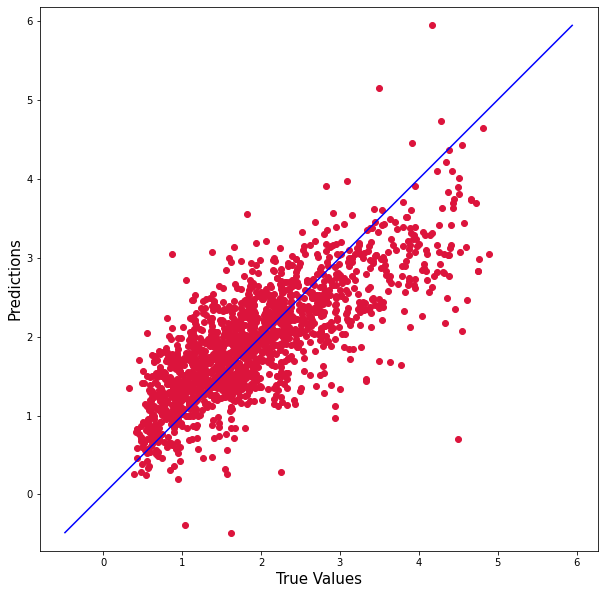

In [78]:
# Visualize the model
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_test_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(Y_test_pred), max(Y_test))
p2 = min(min(Y_test_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
# Print RMSE score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
rms_score = sqrt(mean_squared_error(Y_test, Y_test_pred))
print("RMSE:", rms_score)

# Print MAE score
mae_score = mean_absolute_error(Y_test, Y_test_pred)
print("MAE:", mae_score)

RMSE: 0.6081656271288393
MAE: 0.46601093445126945


11. Display the coefficients of each of the explanatory variables

In [80]:
print(regressor.coef_)

[ 0.89609759  0.16974768 -0.30832739  0.13560531  0.05837722 -0.20841509]


12. Create a DataFrame in which you will have the columns that refer to the right coefficient

In [81]:
coef_table = pd.DataFrame(list(X.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",regressor.coef_.transpose())
coef_table

,0,Coefs
0,MedInc,0.896098
1,HouseAge,0.169748
2,AveRooms,-0.308327
3,AveBedrms,0.135605
4,Population,0.058377
5,AveOccup,-0.208415


13. Now compute the **absolute value** of each coefficient and order them in descending order. What can you conclude now? 

,coefficients
Latitude,0.885875
Longitude,0.855442
MedInc,0.825102
AveBedrms,0.301116
AveRooms,0.265063
HouseAge,0.116986
AveOccup,0.040029
Population,0.006465


---> The most influential columns are Latitude, Longitude, MedInc and the number of beds.

14. In general, one avoids looking at the coefficients to determine the importance of features. Instead, we'll use something other than "f_regression".

Look at the documentation of sckitlearn to try to succeed in setting up this metric.

Feature: 0, Score: 0.89610
Feature: 1, Score: 0.16975
Feature: 2, Score: -0.30833
Feature: 3, Score: 0.13561
Feature: 4, Score: 0.05838
Feature: 5, Score: -0.20842


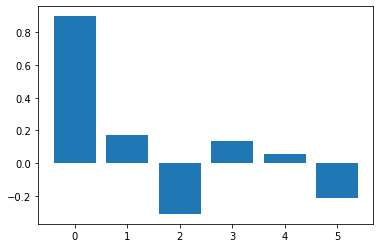

In [82]:
from matplotlib import pyplot
# get importance
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature 0: 11277.254645
Feature 1: 0.201101
Feature 2: 1621.294762
Feature 3: 139.124036
Feature 4: 1.570072
Feature 5: 1139.626318


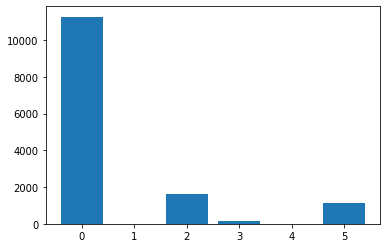

In [83]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, Y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

15. Then put your results in a dataframe so that they can be interpreted.

In [84]:
fs.pvalues_
fs.scores_

array([1.12772546e+04, 2.01100817e-01, 1.62129476e+03, 1.39124036e+02,
       1.57007205e+00, 1.13962632e+03])

In [85]:
pd.DataFrame({'Features': X.columns, 'p_values': fs.pvalues_, 'f values': fs.scores_}, columns=['Features', 'p_values', 'f values'])

,Features,p_values,f values
0,MedInc,0.000000e+00,11277.254645
1,HouseAge,6.538404e-01,0.201101
2,AveRooms,0.000000e+00,1621.294762
3,AveBedrms,5.763522e-32,139.124036
4,Population,2.102165e-01,1.570072
5,AveOccup,1.084729e-240,1139.626318
